# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [4]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: #your answer here

Это происходит из-за использования DummyClassifier с параметром strategy='unform', который случайным образом предсказывает вероятности для каждого класса на основе равномерного распределения. А так как у нас их всего два, то и отсюда такая вероятность. Лучше использовать просто .predict()

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [5]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


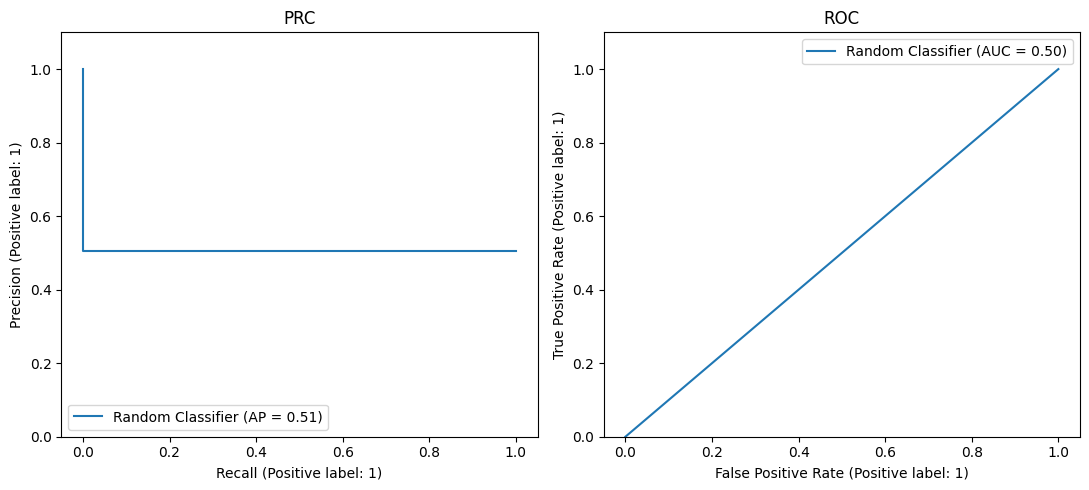

In [6]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [7]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [8]:
#your code here
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.datasets import make_classification

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

param_grid = {'C': np.linspace(1e-10, 3.7, 18)}

scorer = make_scorer(average_precision_score, greater_is_better=True)
grid_search = GridSearchCV(SVC(kernel='linear'), param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_
best_AUC_PR = grid_search.best_score_
print(f'best_C: {best_C["C"]}, best_AUC_PR: {best_AUC_PR}')

best_C: 0.21764705891764707, best_AUC_PR: 0.7184247185437395


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [10]:
#your code here
svc_model = SVC(kernel='linear', C=best_C['C']).fit(X_train, y_train)
y_pred = svc_model.predict(X_test)

Random Classifier with regularization metrics
AUC-PR: 0.82682
AUC-ROC: 0.77381


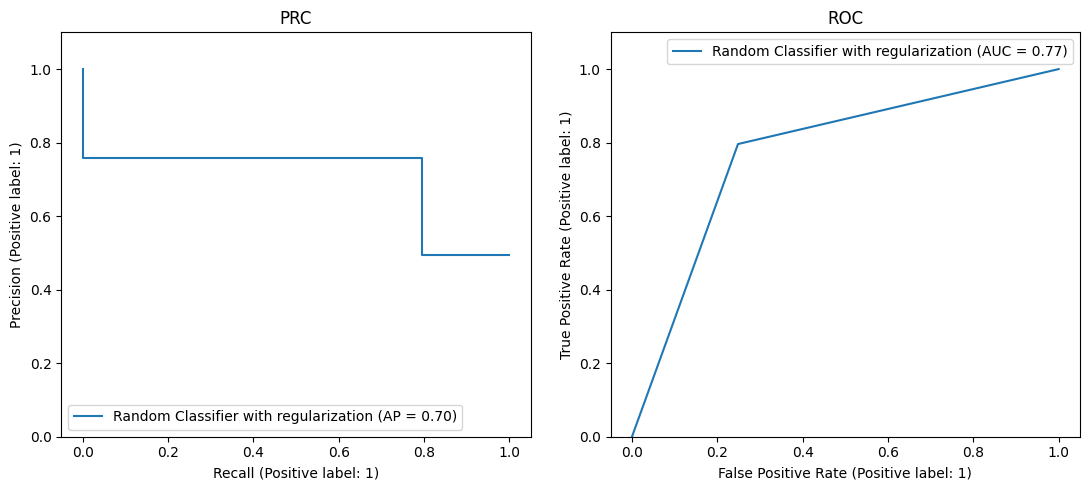

In [11]:
depict_pr_roc(y_test, y_pred, 'Random Classifier with regularization')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [12]:
#your code here
precision, recall, _ = precision_recall_curve(y_test, y_pred)
df_metrics.loc['Random Classifier with regularization'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred),
      best_C['C']
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
Random Classifier with regularization,0.826819,0.773813,0.217647


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [13]:
#your code here
from sklearn.linear_model import LogisticRegression

In [14]:
param_grid = {'C': np.linspace(1e-10, 3.7, 18)}

scorer = make_scorer(average_precision_score, greater_is_better=True)
grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)

best_l2 = grid_search.best_params_
best_AUC_PR = grid_search.best_score_
print(f'best_l2: {best_l2["C"]}, best_AUC_PR: {best_AUC_PR}')

best_l2: 0.21764705891764707, best_AUC_PR: 0.7169095159265106


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

In [15]:
#your code here
logistic_model = LogisticRegression(C=best_l2['C']).fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

Random Classifier for LogisticRegression metrics
AUC-PR: 0.82757
AUC-ROC: 0.77456


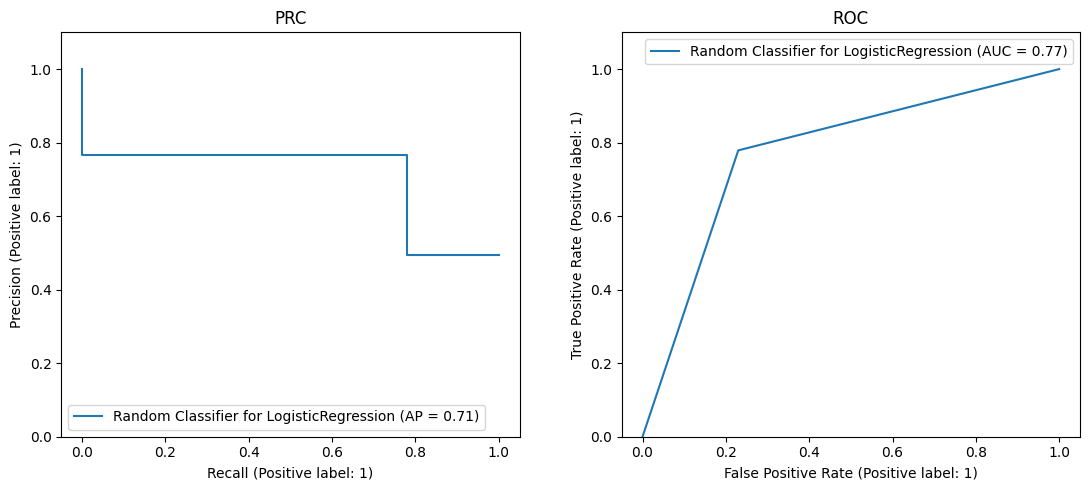

In [16]:
depict_pr_roc(y_test, y_pred, 'Random Classifier for LogisticRegression')

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



In [17]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
df_metrics.loc['Random Classifier for LogisticRegression'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred),
      best_l2['C']
]
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
Random Classifier with regularization,0.826819,0.773813,0.217647
Random Classifier for LogisticRegression,0.827569,0.774561,0.217647


**Ответ:** # your answer here

Как можно заметить AUC-ROC увеличился (и больше не равняяется 0.5, что означало случайное угадывание), также увеличился и AUC-PR (в двух последних случаях значения практически одинаковые).

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [18]:
#your code here
X, y = make_classification(
    n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
svc_model = SVC(kernel='linear', C=best_C['C'], random_state=42).fit(X_train, y_train)

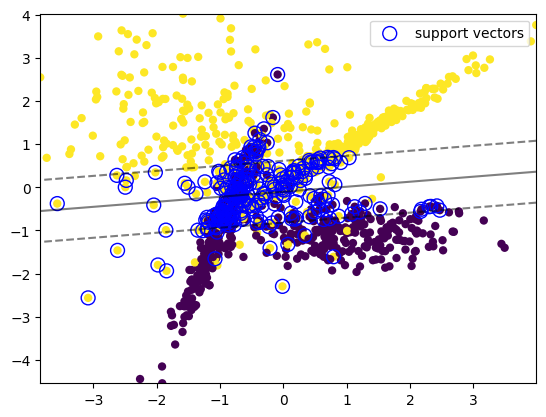

In [19]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape) #your code here

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(#your code here
                X[:, 0],
                X[:, 1],
                c=y,
                cmap='viridis',
                edgecolors='none',
                marker='o'
                )

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(#your code here
                   model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, svc_model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** #your answer here

Круги, расположенные на границе между классами данных. Эти круги определяют, где проходит граница между классами.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [20]:
logistic_model = LogisticRegression(C=best_l2['C'],).fit(X_train, y_train)

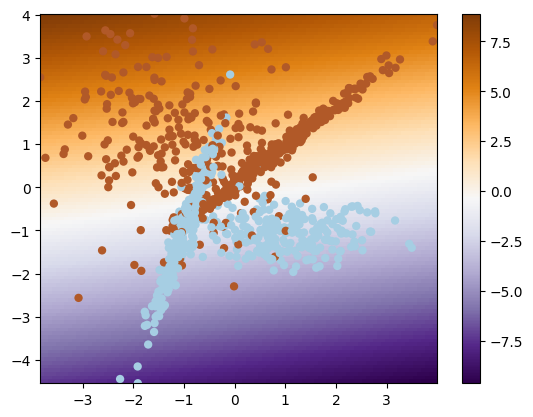

In [21]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.decision_function(xy).reshape(XX.shape) #your code here
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(#your code here
                X[:, 0],
                X[:, 1],
                c=y,
                cmap=plt.cm.Paired,
                edgecolors='none',
                marker='o')

    plt.colorbar(image)


plot_logreg_2D(X, y, logistic_model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** #your answer here

На картинке область, где модель не уверена визуализирована как область, в которой нет опорных объектов. Это значит, что в этой области данные из обоих классов находятся близко друг к другу, и модель не может однозначно определить, к какому классу относится новый объект.

Если в области нет опорных объектов, это означает, что опорная гиперплоскость проходит через эту область. В этом случае модель не может однозначно определить, к какому классу относится новый объект, который находится в этой области.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [22]:
y_pred = logistic_model.predict_proba(X_test)

In [23]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds[:, 1] >= l) & (preds[:, 1] < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, label='Calibration Curve')
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.grid()

In [24]:
def show_perfect_line():
    plt.plot([0, 1], [0, 1], label='perfect', linestyle='--', color='red')
    plt.legend()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [25]:
#your code here
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
svc_model = SVC(kernel='linear', C=best_C['C'], probability=True).fit(X_train, y_train)
logistic_model = LogisticRegression(C=best_l2['C']).fit(X_train, y_train)

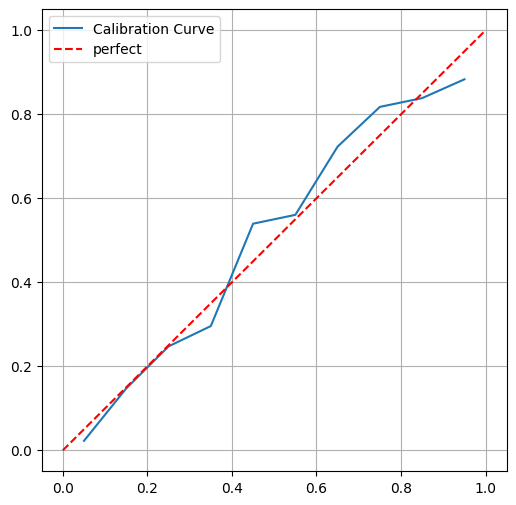

In [27]:
plot_calibration_curve(y_test, svc_model.predict_proba(X_test))
show_perfect_line()

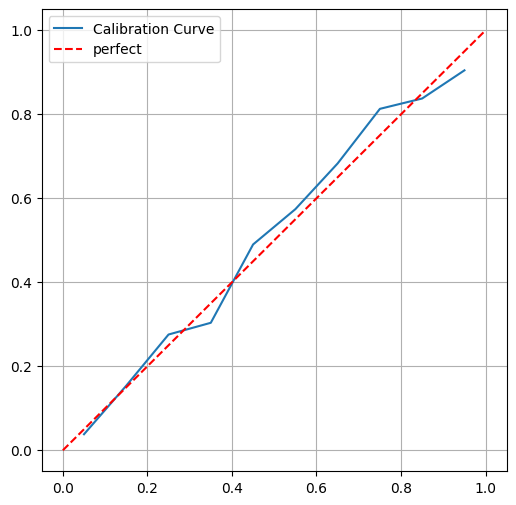

In [28]:
plot_calibration_curve(y_test, logistic_model.predict_proba(X_test))
show_perfect_line()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** #your answer here

Да, в целом хорошо, и SVM, и logistic regression находятся радом с идеальной линией.

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

In [29]:
#your code here
svc_dist = svc_model.decision_function(X_test)
logistic_dist = logistic_model.decision_function(X_test)

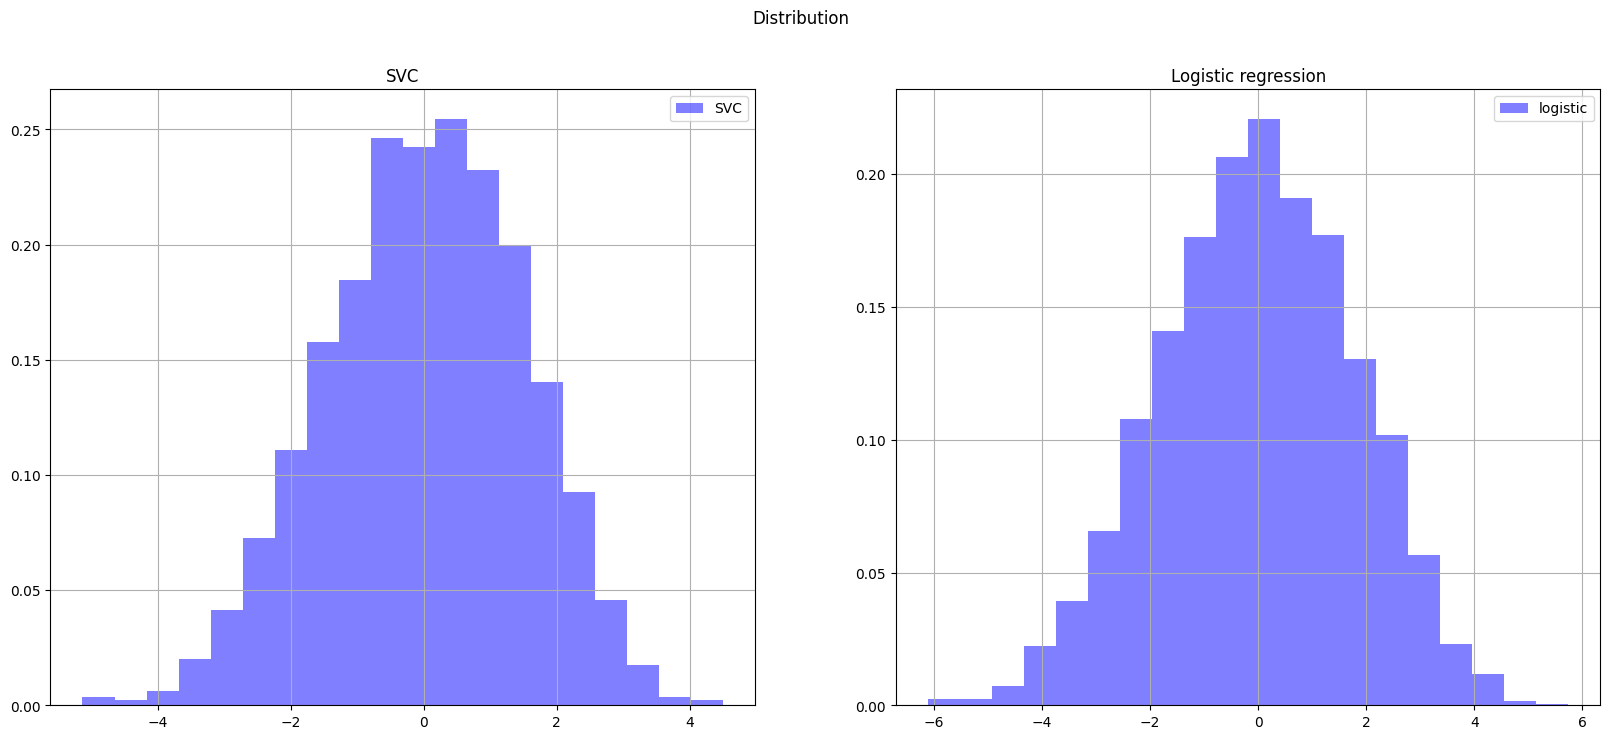

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].hist(svc_dist, bins=20, density=True, alpha=0.5, color='blue', label='SVC')
axs[0].set(title='SVC')
axs[0].legend()
axs[0].grid(True)

axs[1].hist(logistic_dist, bins=20, density=True, alpha=0.5, color='blue', label='logistic')
axs[1].set(title='Logistic regression')
axs[1].legend()
axs[1].grid(True)

plt.suptitle('Distribution')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** #your answer here

Можно заметить, что вторая гистограмма имеет более длинный хвост, значит SVC менее чувствительнее к выбросам. Однако распределение Logistic regression более симметричное, что может означать, что оно с большей уверенностью разделяет данные на два класса.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [31]:
#your code here
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [32]:
svc_model = SVC(kernel='linear', C=best_C['C'], probability=True).fit(X_train, y_train)
calibrated_svc = CalibratedClassifierCV(svc_model, method='sigmoid', cv='prefit')
calibrated_svc.fit(X_train, y_train)
calibrated_svc_probs = calibrated_svc.predict_proba(X_test)[:, 1]

print('SVC-ROC-AUC:', roc_auc_score(y_test, calibrated_svc_probs))

SVC-ROC-AUC: 0.8479137987057004


In [33]:
def temp_plot_calibration_curve(y_true, probas, ax, label):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, probas, n_bins=10)
    ax.plot(mean_predicted_value, fraction_of_positives, 's-', label=label)
    ax.set(title='Calibration Curve')

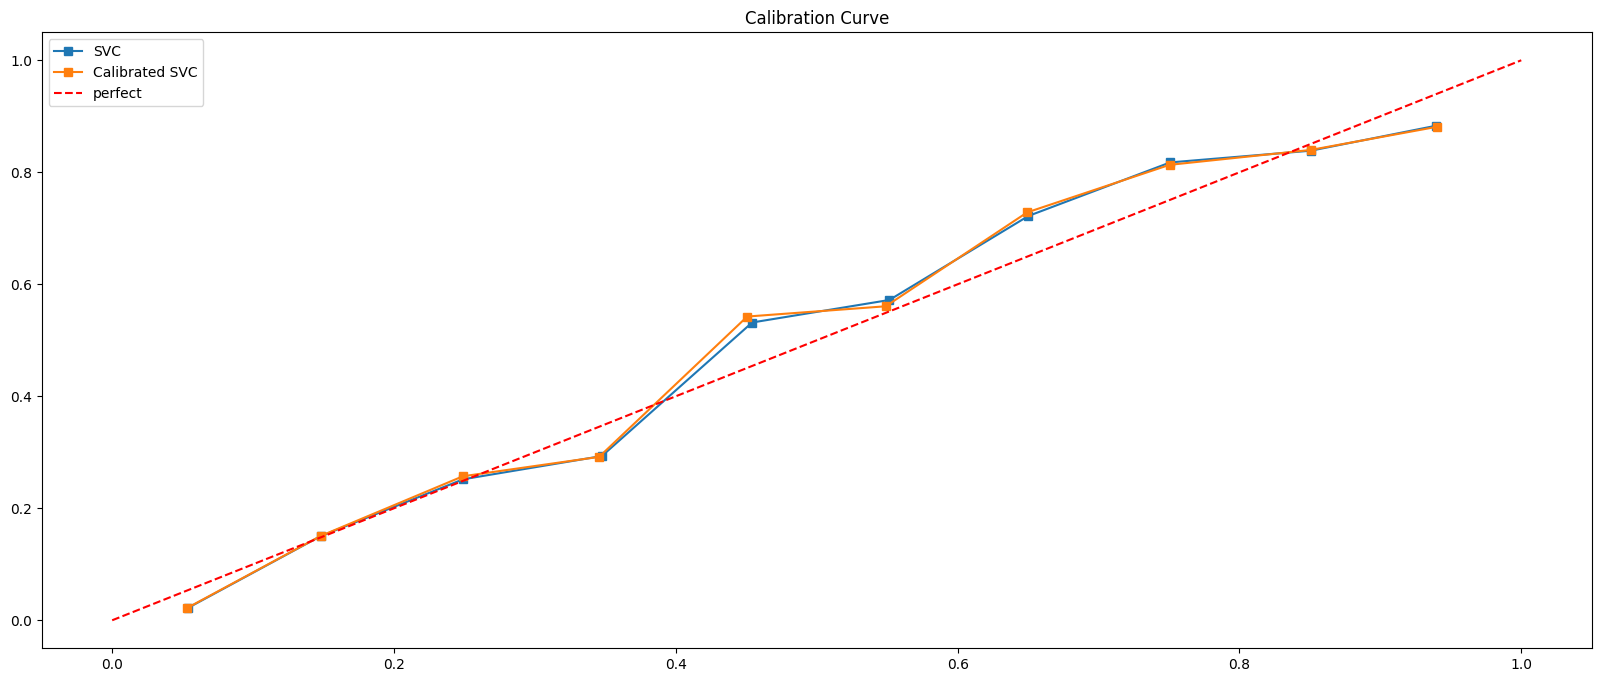

In [34]:
fig, ax = plt.subplots(figsize=(20, 8))
temp_plot_calibration_curve(y_test, svc_model.predict_proba(X_test)[:, 1], ax, label='SVC')
temp_plot_calibration_curve(y_test, calibrated_svc.predict_proba(X_test)[:, 1], ax, label='Calibrated SVC')

show_perfect_line()
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** #your answer here

Сложно сказать, так как она практически не изменилась и изначально была близка к диагональной.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [35]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [36]:
!wget -O 'bike_buyers.csv' https://www.dropbox.com/scl/fi/qq8clu1y2k71j89ugjso2/bike_buyers.csv?rlkey=1579lqwh2kv52jkar0xxkzmbn&dl=0

--2023-11-26 08:36:06--  https://www.dropbox.com/scl/fi/qq8clu1y2k71j89ugjso2/bike_buyers.csv?rlkey=1579lqwh2kv52jkar0xxkzmbn
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd0403c9cd0c01d8f5a8ec69f7f.dl.dropboxusercontent.com/cd/0/inline/CIQ9ea-hkzCKSQ9K9hiGAbCgf8cEy8n_W-eYafrJBqltUVZRSD4SiLy9_5gkQbzfCw2CYG8S9ntM3MQOSs2h49lTsKaQETrUOvEQKWifUsPA7oZPEC2IIUMQRAR4fMUvybAh26dMXXjA_MyoYalMEytO/file# [following]
--2023-11-26 08:36:07--  https://ucd0403c9cd0c01d8f5a8ec69f7f.dl.dropboxusercontent.com/cd/0/inline/CIQ9ea-hkzCKSQ9K9hiGAbCgf8cEy8n_W-eYafrJBqltUVZRSD4SiLy9_5gkQbzfCw2CYG8S9ntM3MQOSs2h49lTsKaQETrUOvEQKWifUsPA7oZPEC2IIUMQRAR4fMUvybAh26dMXXjA_MyoYalMEytO/file
Resolving ucd0403c9cd0c01d8f5a8ec69f7f.dl.dropboxusercontent.com (ucd0403c9cd0c01d8f5a8ec69f7f.dl.dropboxusercontent.com)... 162.125.2.15, 26

In [37]:
df = pd.read_csv('bike_buyers.csv')
#Заменим пропуски категориальных переменных
#your code here
df_categorical = df.select_dtypes(include=['object'])
df[df_categorical.columns] = df_categorical.fillna('undefined')

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = X.select_dtypes(exclude=['object']) #your code here
X_categorical = X.select_dtypes(include=['object']) #your code here

In [38]:
df.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,undefined,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


In [39]:
numerical = [column for column in X_numerical.columns if column != 'ID']
categorical = list(X_categorical.columns)

В начале поработаем только с категориальными признаками

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [41]:
#your code here
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
import time

In [42]:
column_transformer = ColumnTransformer([
    ('oe', OrdinalEncoder(), categorical)
])

pipeline = Pipeline(steps=[
    ('oe', column_transformer),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))
])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

time: 0.014568328857421875


logistic regression and OrdinalEncoder metrics
AUC-PR: 0.64757
AUC-ROC: 0.55513


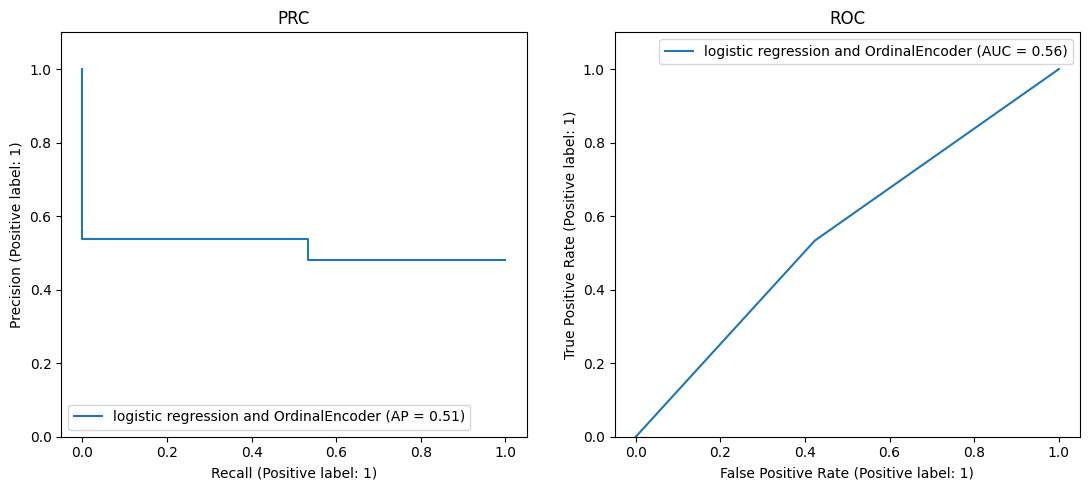

In [43]:
y_pred = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'logistic regression and OrdinalEncoder')

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [44]:
#your code here
from sklearn.preprocessing import OneHotEncoder

In [45]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))
])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

time: 0.03755927085876465


logistic regression and One-Hot Encoding  metrics
AUC-PR: 0.71727
AUC-ROC: 0.62340


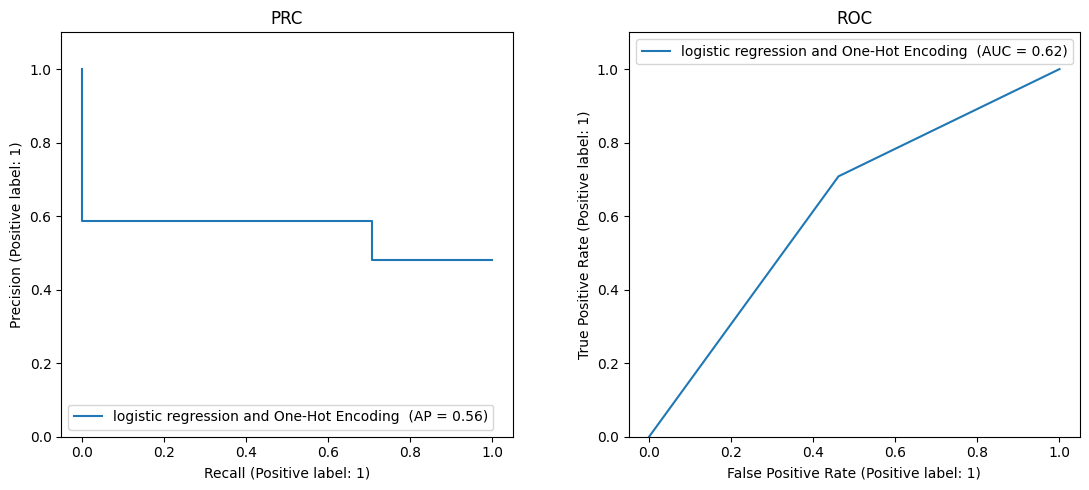

In [46]:
y_pred = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'logistic regression and One-Hot Encoding ')

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [47]:
#your code here
from sklearn.base import BaseEstimator, TransformerMixin

In [48]:
class MeanTargetEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, categorical):
        self.categorical = categorical

    def fit(self, X, y):
        self.X_train = X.copy()
        self.X_train['Purchased Bike'] = y
        return self

    def transform(self, X, y=None):
        X_coding = X.copy()
        for column in self.categorical:
            X_coding[column] = X_coding[column].map(self.X_train.groupby(column)['Purchased Bike'].mean())
        return X_coding

In [49]:
column_transformer = ColumnTransformer([
    ('mte', MeanTargetEncoding(categorical), categorical)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('mean_target', column_transformer),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))
])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

time: 0.03185391426086426


В сравненении с OHE, время немного уменьшилось.

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

logistic regression and Mean-target Encoding metrics
AUC-PR: 0.86730
AUC-ROC: 0.82866


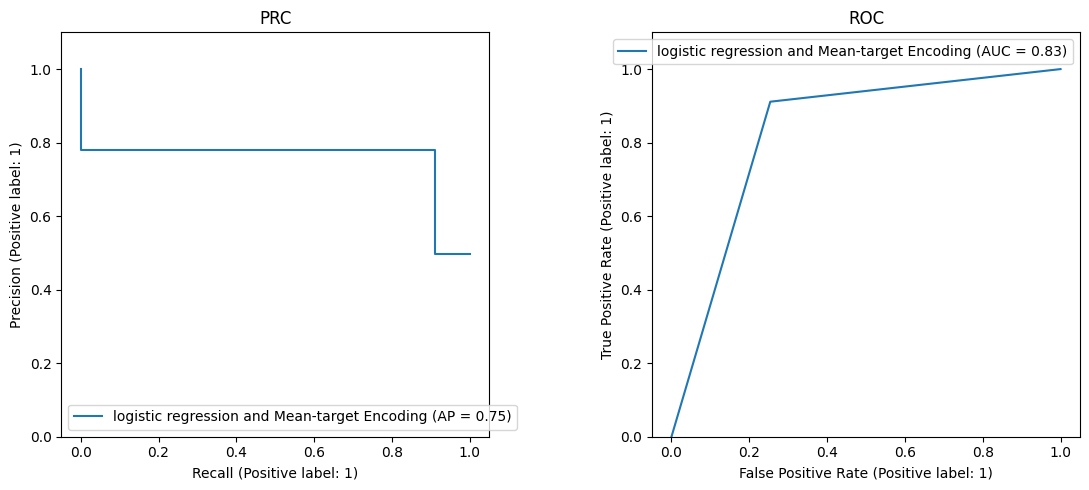

In [50]:
#your code here
y_test = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'logistic regression and Mean-target Encoding')

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [51]:
#your code here
class MeanTargetEncodingWithNoise(BaseEstimator, TransformerMixin):
    def __init__(self, categorical, noise_lvl):
        self.categorical = categorical
        self.noise_lvl = noise_lvl

    def fit(self, X, y):
        self.X_train = X.copy()
        self.X_train['Purchased Bike'] = y
        return self

    def transform(self, X, y=None):
        X_coding = X.copy()
        for column in self.categorical:
            noise = np.random.normal(0, self.noise_lvl, size=len(X_coding))
            X_coding[column] = (
                X_coding[column].map(self.X_train.groupby(column)['Purchased Bike'].mean())
                + noise
            )
        return X_coding

In [52]:
mte_with_noise = MeanTargetEncodingWithNoise(categorical, noise_lvl=0.02)

column_transformer = ColumnTransformer([
    ('mte', mte_with_noise, categorical)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('mean_target', column_transformer),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))
])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

time: 0.025812149047851562


logistic regression and Mean-target Encoding + noise metrics
AUC-PR: 0.88571
AUC-ROC: 0.83626


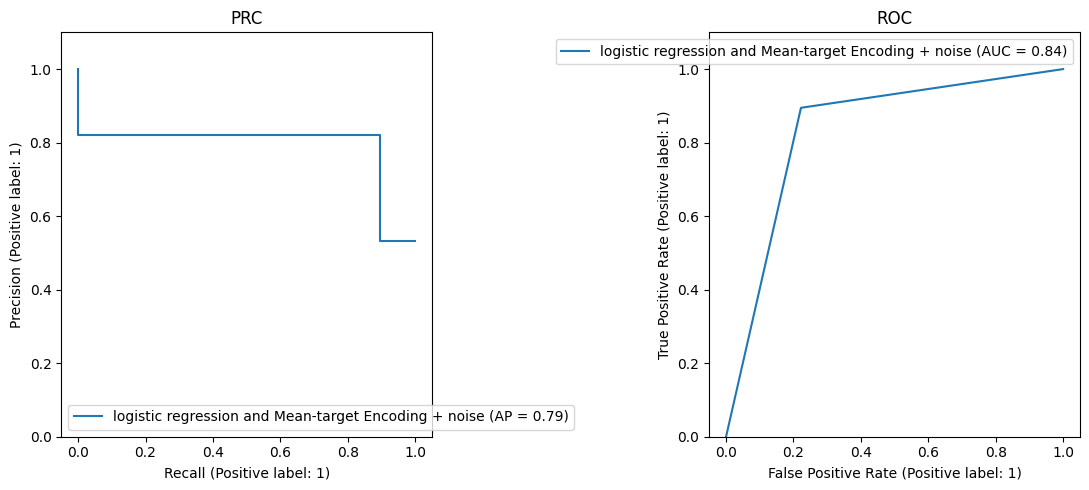

In [53]:
y_test = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'logistic regression and Mean-target Encoding + noise')

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** #your answer here

Хоть время обучения и увеличилось, однако показатели AUC-PR и AUC-ROC улучшились, что может свидетельствовать о более устойчивой модели.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [54]:
#your code here
from sklearn.model_selection import StratifiedKFold

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [55]:
#your code here
class MeanTargetEncodingWithNoise(BaseEstimator, TransformerMixin):
    def __init__(self, categorical, noise_lvl, C):
        self.categorical = categorical
        self.noise_lvl = noise_lvl
        self.C = C

    def fit(self, X, y):
        self.X_train = X.copy()
        self.X_train['Purchased Bike'] = y
        self.global_mean = y.mean()
        return self

    def transform(self, X, y=None):
        X_coding = X.copy()
        for column in self.categorical:
            noise = np.random.normal(0, self.noise_lvl, size=len(X_coding))
            mean_target = self.X_train.groupby(column)['Purchased Bike'].mean()
            category_counts = self.X_train[column].value_counts()

            X_coding[column] = (
                X_coding[column].map(
                    (mean_target * category_counts + self.C * self.global_mean) /
                    (category_counts + self.C)
                )
                + noise
            )
        return X_coding

In [56]:
mte_with_noise = MeanTargetEncodingWithNoise(categorical, noise_lvl=0.02, C=10)

column_transformer = ColumnTransformer([
    ('mte', mte_with_noise, categorical)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('mean_target', column_transformer),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))
])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

time: 0.03257894515991211


logistic regression and Mean-target Encoding + smooth metrics
AUC-PR: 0.87801
AUC-ROC: 0.82892


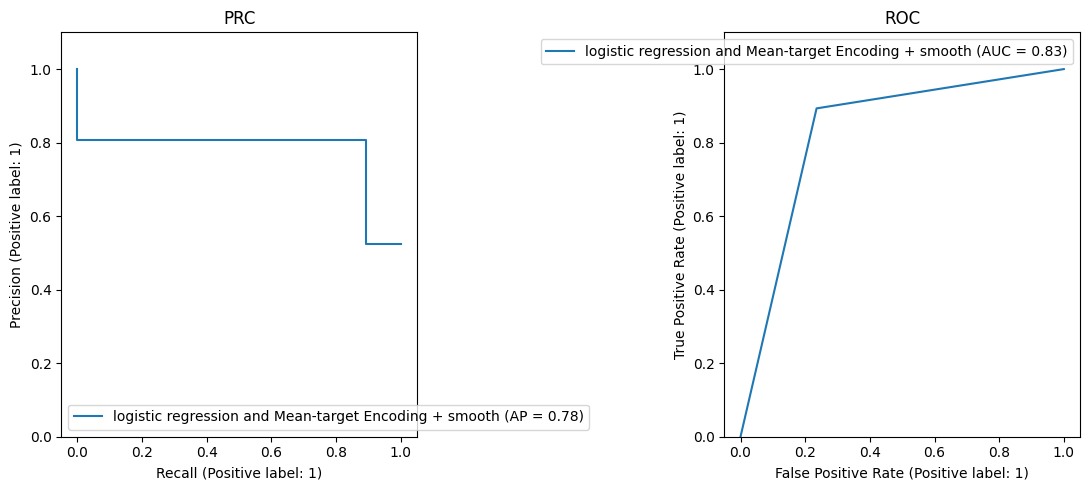

In [57]:
y_test = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'logistic regression and Mean-target Encoding + smooth')

Время опять же чуть больше, чем при OHE, но AUC-PR и AUC-ROC значительно лучше.

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [58]:
#your code here
X[numerical].isna().sum()

Income      6
Children    8
Cars        9
Age         8
dtype: int64

In [59]:
X[numerical][X[numerical].isna().any(axis=1)].head()

,Income,Children,Cars,Age
9,NaN,2.0,1.0,NaN
12,170000.0,5.0,NaN,55.0
98,40000.0,0.0,0.0,NaN
110,NaN,1.0,0.0,46.0
117,20000.0,NaN,0.0,40.0


In [60]:
X[numerical] = X[numerical].fillna(X[numerical].mean())

In [61]:
X.isna().sum()

ID                  0
Marital Status      0
Gender              0
Income              0
Children            0
Education           0
Occupation          0
Home Owner          0
Cars                0
Commute Distance    0
Region              0
Age                 0
dtype: int64

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [62]:
#your code here
X[numerical].nunique()

Income      17
Children     7
Cars         6
Age         54
dtype: int64

In [63]:
categorical = ['Marital Status',
                'Gender',
                'Education',
                'Occupation',
                'Home Owner',
                'Commute Distance',
                'Region',
                'Income',
                'Children',
                'Cars',
                'Age']

numerical = [# 'Income',
            #  'Children',
            #  'Cars',
            #  'Age'
             ]
X_train, X_test, y_train, y_test = train_test_split(X[categorical], y, test_size=0.25, random_state=777, stratify=y)

In [64]:
mte_with_noise = MeanTargetEncodingWithNoise(categorical, noise_lvl=0.02, C=10)

column_transformer = ColumnTransformer([
    ('mte', mte_with_noise, categorical)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('mean_target', column_transformer),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))
])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

time: 0.038773298263549805


NumericCounterEncoding metrics
AUC-PR: 0.77539
AUC-ROC: 0.68218


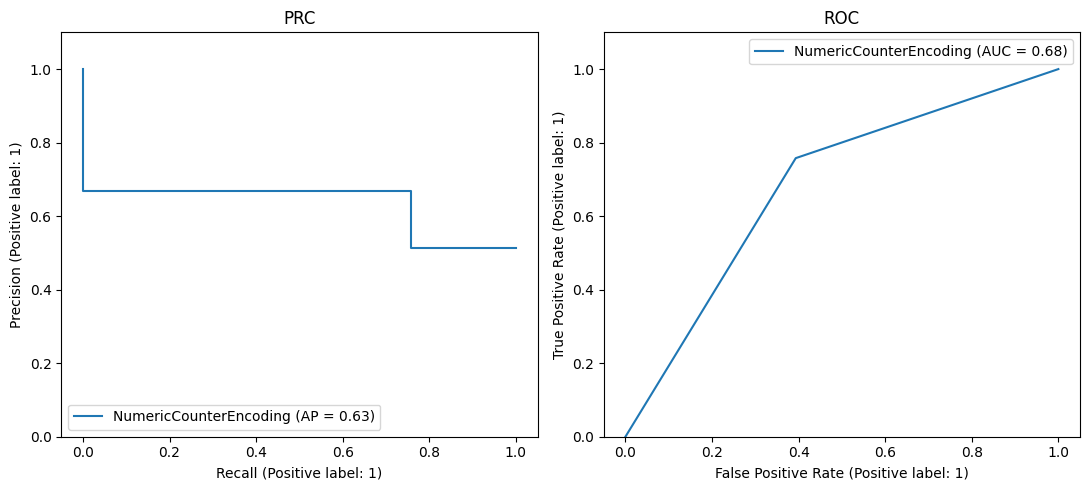

In [65]:
y_test = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'NumericCounterEncoding')

In [66]:
categorical = ['Marital Status',
                'Gender',
                'Education',
                'Occupation',
                'Home Owner',
                'Commute Distance',
                'Region',
                'Income',
                # 'Children',
                # 'Cars',
                # 'Age'
               ]

numerical = [#'Income',
             'Children',
             'Cars',
             'Age'
             ]
X_train, X_test, y_train, y_test = train_test_split(X[categorical], y, test_size=0.25, random_state=777, stratify=y)

In [67]:
mte_with_noise = MeanTargetEncodingWithNoise(categorical, noise_lvl=0.02, C=10)

column_transformer = ColumnTransformer([
    ('mte', mte_with_noise, categorical)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('mean_target', column_transformer),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))
])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

time: 0.04565548896789551


NumericCounterEncoding metrics
AUC-PR: 0.84500
AUC-ROC: 0.78624


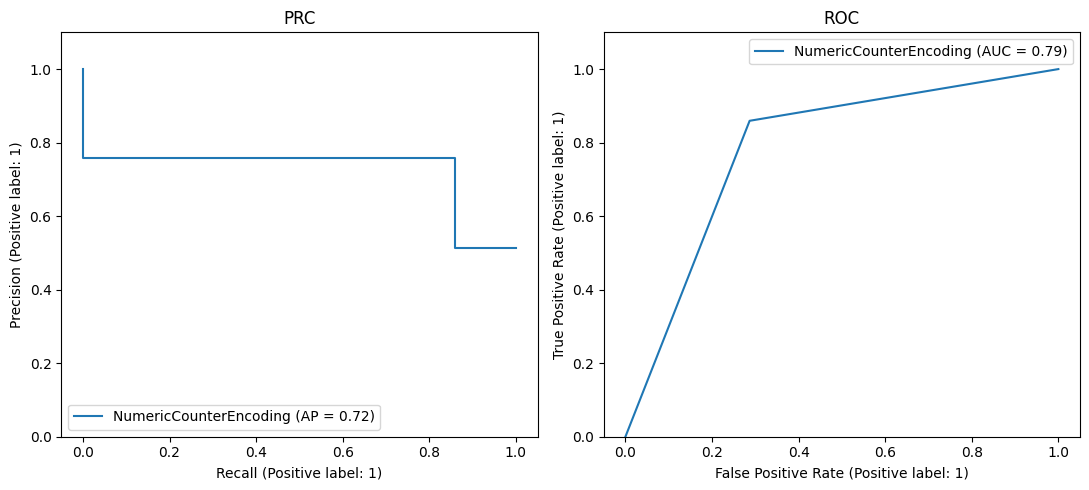

In [68]:
y_test = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'NumericCounterEncoding')

In [69]:
categorical = ['Marital Status',
                'Gender',
                'Education',
                'Occupation',
                'Home Owner',
                'Commute Distance',
                'Region',
                # 'Income',
                'Children',
                # 'Cars',
                # 'Age'
               ]

numerical = ['Income',
            #  'Children',
             'Cars',
             'Age'
             ]
X_train, X_test, y_train, y_test = train_test_split(X[categorical], y, test_size=0.25, random_state=777, stratify=y)

In [70]:
mte_with_noise = MeanTargetEncodingWithNoise(categorical, noise_lvl=0.02, C=10)

column_transformer = ColumnTransformer([
    ('mte', mte_with_noise, categorical)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('mean_target', column_transformer),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))
])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

time: 0.030137062072753906


NumericCounterEncoding metrics
AUC-PR: 0.86948
AUC-ROC: 0.78642


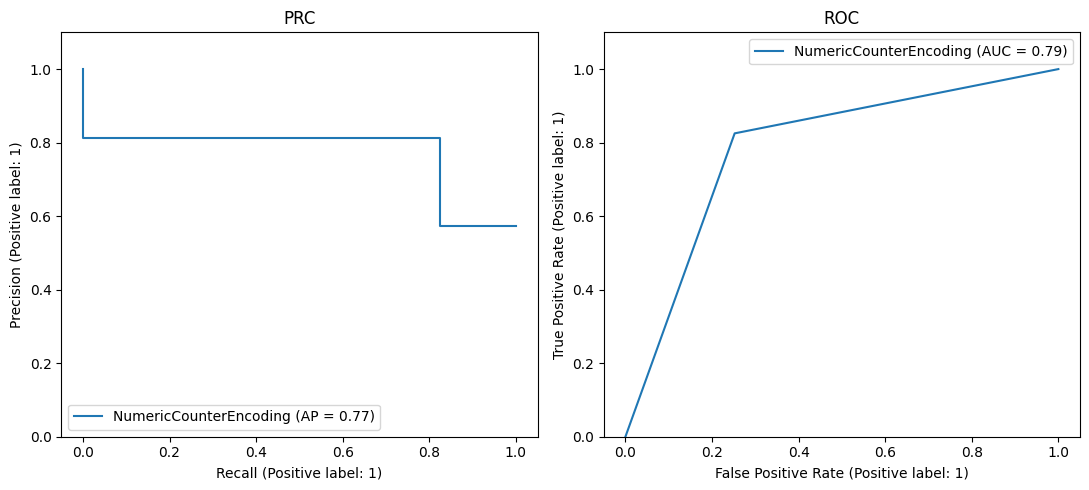

In [71]:
y_test = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'NumericCounterEncoding')

In [72]:
categorical = ['Marital Status',
                'Gender',
                'Education',
                'Occupation',
                'Home Owner',
                'Commute Distance',
                'Region',
                # 'Income',
                # 'Children',
                'Cars',
                # 'Age'
               ]

numerical = ['Income',
             'Children',
            #  'Cars',
             'Age'
             ]
X_train, X_test, y_train, y_test = train_test_split(X[categorical], y, test_size=0.25, random_state=777, stratify=y)

In [73]:
mte_with_noise = MeanTargetEncodingWithNoise(categorical, noise_lvl=0.02, C=10)

column_transformer = ColumnTransformer([
    ('mte', mte_with_noise, categorical)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('mean_target', column_transformer),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))
])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

time: 0.02921581268310547


NumericCounterEncoding metrics
AUC-PR: 0.81532
AUC-ROC: 0.74738


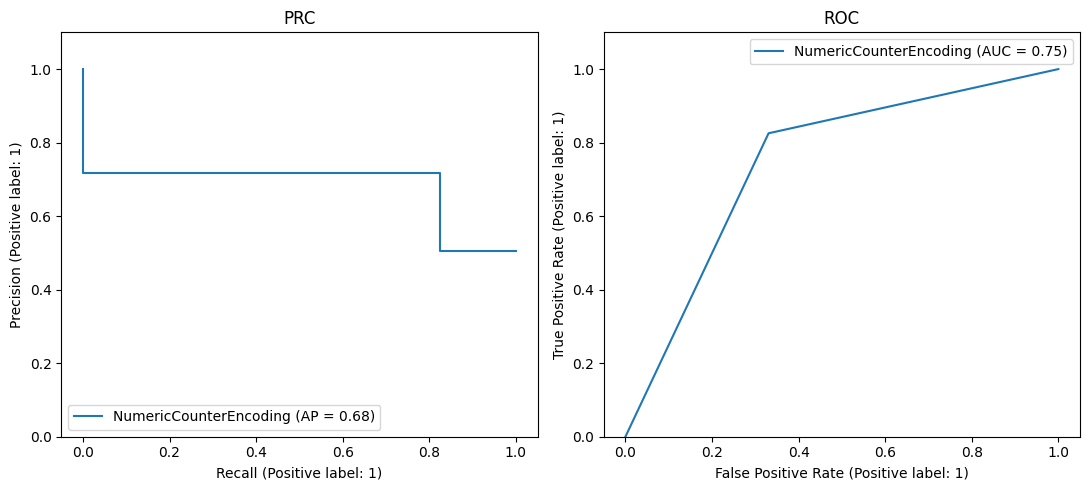

In [74]:
y_test = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'NumericCounterEncoding')

In [75]:
categorical = ['Marital Status',
                'Gender',
                'Education',
                'Occupation',
                'Home Owner',
                'Commute Distance',
                'Region',
                # 'Income',
                #  'Children',
                #  'Cars',
                 'Age'
              ]

numerical = ['Income',
             'Children',
             'Cars',
            #   'Age'
             ]
X_train, X_test, y_train, y_test = train_test_split(X[categorical], y, test_size=0.25, random_state=777, stratify=y)

In [76]:
mte_with_noise = MeanTargetEncodingWithNoise(categorical, noise_lvl=0.02, C=10)

column_transformer = ColumnTransformer([
    ('mte', mte_with_noise, categorical)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('mean_target', column_transformer),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))
])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

time: 0.02869439125061035


NumericCounterEncoding metrics
AUC-PR: 0.74452
AUC-ROC: 0.67467


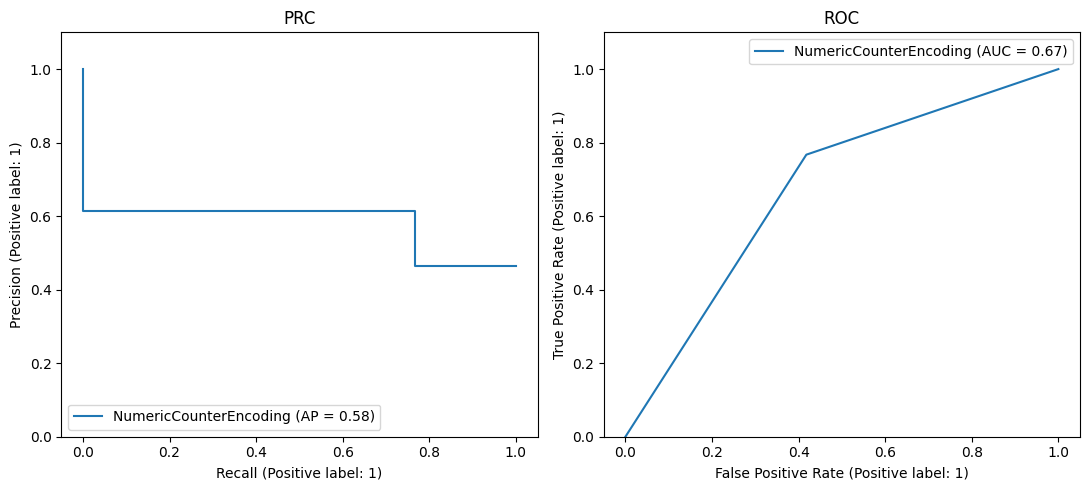

In [77]:
y_test = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'NumericCounterEncoding')

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ #your answer here

Лучше всего, как категориальный признак, показало себя "количество детей".
Но лучший результат обойти не удалось, так что кажется, все на своих местах.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [154]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-26 10:20:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.1’

adult.data.1            [ <=>                ]   3.79M  --.-KB/s    in 0.09s   

2023-11-26 10:20:33 (41.6 MB/s) - ‘adult.data.1’ saved [3974305]



In [155]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
23112,20,Private,243178,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,28,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [156]:
#your code here
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(df, y, train_size=0.75, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [157]:
#your code here
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [158]:
categorical = ['workclass',
               'education',
               'marital-status',
               'occupation',
               'relationship',
               'race',
               'sex',
               'native-country']

numerical = ['age',
             'education-num',
             'capital-gain',
             'capital-loss',
             'hours-per-week']

other = ['fnlwgt']

In [159]:
from sklearn.preprocessing import StandardScaler

In [160]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
])

column_transformer.fit(X_train)

print(f'Количество категориальных признаков до OneHot-кодирования: {len(categorical)}')
print(f'Количество категориальных признаков после OneHot-кодирования: {column_transformer.transform(X_train).shape[1]}')

Количество категориальных признаков до OneHot-кодирования: 8
Количество категориальных признаков после OneHot-кодирования: 102


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [162]:
#your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numerical)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))
])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

time: 0.19750642776489258


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic regression and One-Hot Encoding  metrics
AUC-PR: 0.72564
AUC-ROC: 0.82128


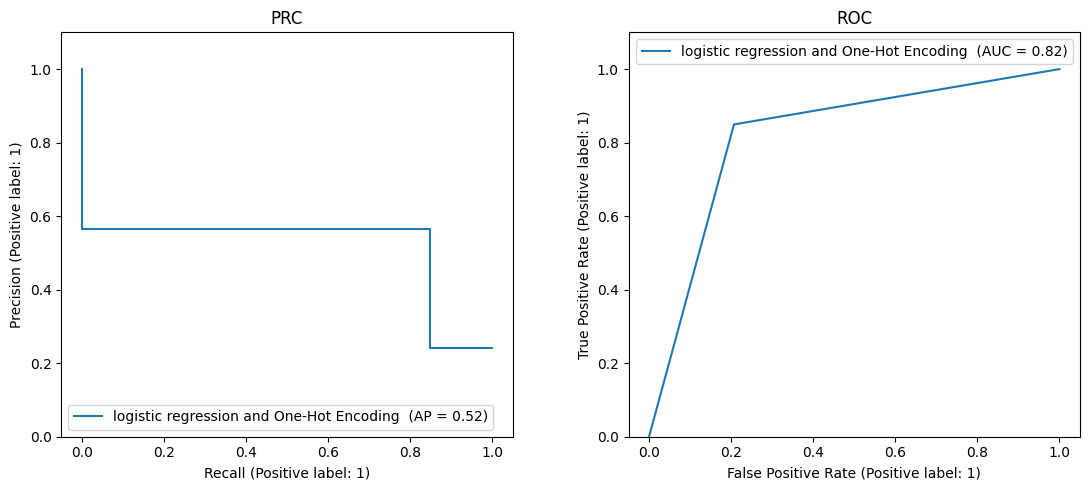

In [163]:
y_pred = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'logistic regression and One-Hot Encoding ')

#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [164]:
#your code here
from sklearn.feature_selection import SelectFromModel

In [165]:
ohe_and_scaling = model.named_steps['ohe_and_scaling']

feature_res_0 = ohe_and_scaling.transformers_[0][1].get_feature_names_out()
feature_res_1 = ohe_and_scaling.transformers_[1][1].get_feature_names_out()

combined_feature_names = np.append(feature_res_0, feature_res_1.reshape(-1, 1))
feature_names = combined_feature_names

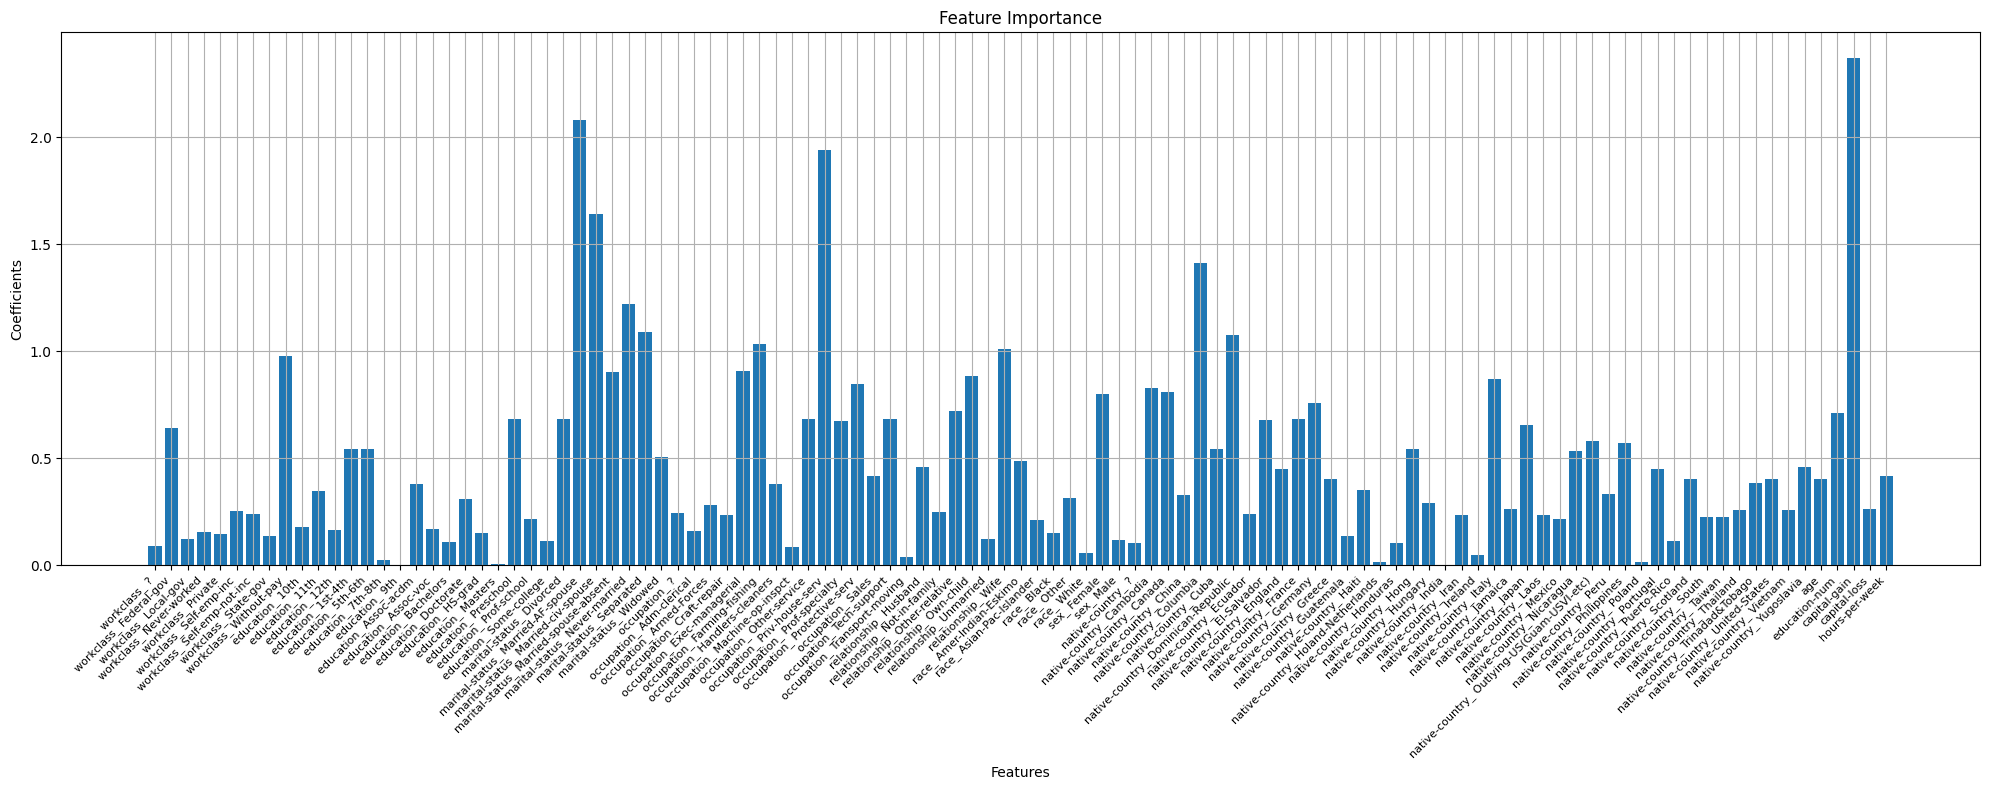

In [166]:
coefficients = np.abs(model.named_steps['logistic_regression'].coef_[0])
plt.figure(figsize=(20, 8))
plt.bar(x=feature_names, height=coefficients)

plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Coefficients')

plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.grid(True)

plt.show()

In [167]:
threshold = np.sort(coefficients)[-40]
selector = SelectFromModel(model.named_steps['logistic_regression'], threshold=threshold)
selected_features = feature_names[selector.get_support()]
selected_features

array(['workclass_ Federal-gov', 'workclass_ Without-pay',
       'education_ 1st-4th', 'education_ 5th-6th', 'education_ Preschool',
       'marital-status_ Divorced', 'marital-status_ Married-AF-spouse',
       'marital-status_ Married-civ-spouse',
       'marital-status_ Married-spouse-absent',
       'marital-status_ Never-married', 'marital-status_ Separated',
       'marital-status_ Widowed', 'occupation_ Exec-managerial',
       'occupation_ Farming-fishing', 'occupation_ Other-service',
       'occupation_ Priv-house-serv', 'occupation_ Prof-specialty',
       'occupation_ Protective-serv', 'occupation_ Tech-support',
       'relationship_ Other-relative', 'relationship_ Own-child',
       'relationship_ Wife', 'race_ Amer-Indian-Eskimo', 'sex_ Female',
       'native-country_ Cambodia', 'native-country_ Canada',
       'native-country_ Columbia', 'native-country_ Cuba',
       'native-country_ Dominican-Republic',
       'native-country_ El-Salvador', 'native-country_ France',

In [168]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numerical)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('feature-selection', selector),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))

])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

time: 0.3489992618560791


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression and One-Hot Encoding best 40 metrics
AUC-PR: 0.71076
AUC-ROC: 0.80743


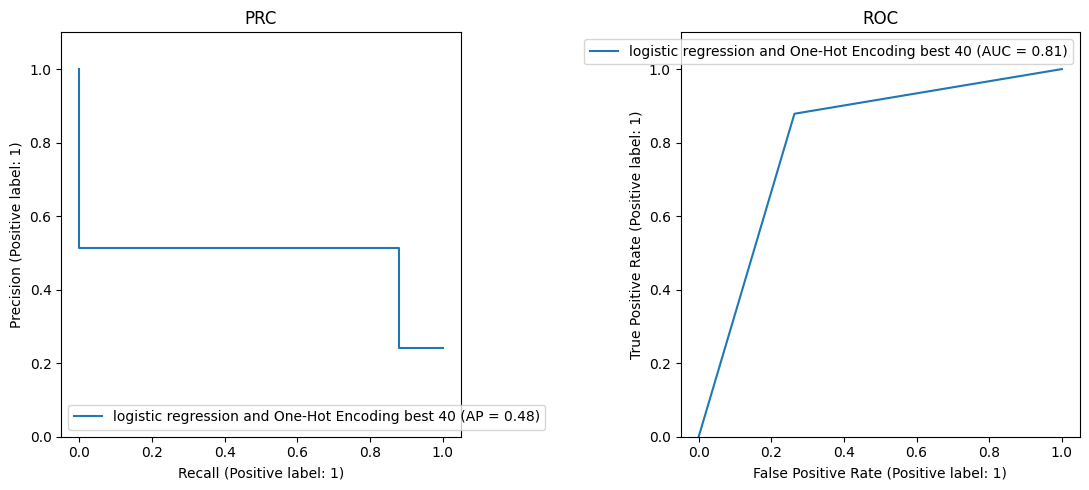

In [169]:
y_pred = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'logistic regression and One-Hot Encoding best 40')

Изменилось ли качество? Как?

AUC-PR уменьшился на одну сотую.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [170]:
#your code here
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))

])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

time: 0.18665742874145508


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic regression and One-Hot Encoding metrics
AUC-PR: 0.70343
AUC-ROC: 0.80060


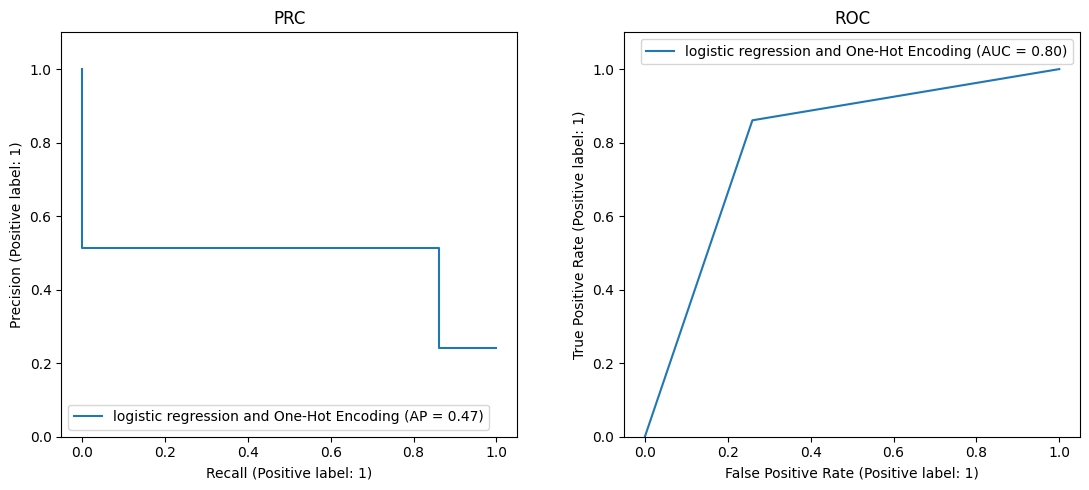

In [171]:
y_pred = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'logistic regression and One-Hot Encoding')

In [172]:
coefficients = np.abs(model.named_steps['logistic_regression'].coef_[0])
threshold = np.sort(coefficients)[-40]
selector = SelectFromModel(model.named_steps['logistic_regression'], threshold=threshold)

In [173]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('feature-selection', selector),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))

])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

time: 0.32973599433898926


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic regression and One-Hot Encoding metrics
AUC-PR: 0.69902
AUC-ROC: 0.79512


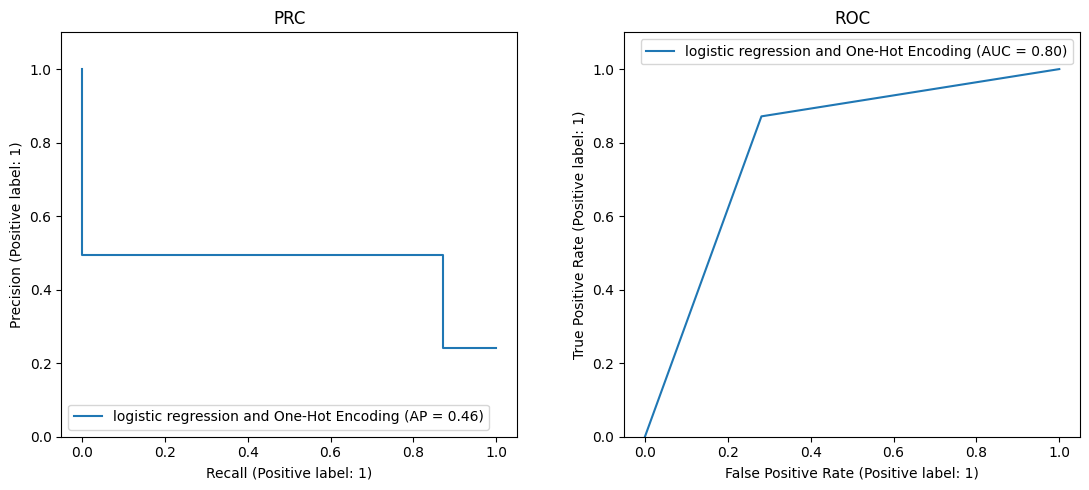

In [174]:
y_pred = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'logistic regression and One-Hot Encoding')

То есть лучше сначала масштабировать, а потом отбирать.

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [188]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numerical)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('feature-selection', selector),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))

])
model = pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

logistic regression and One-Hot Encoding metrics
AUC-PR: 0.71042
AUC-ROC: 0.80698


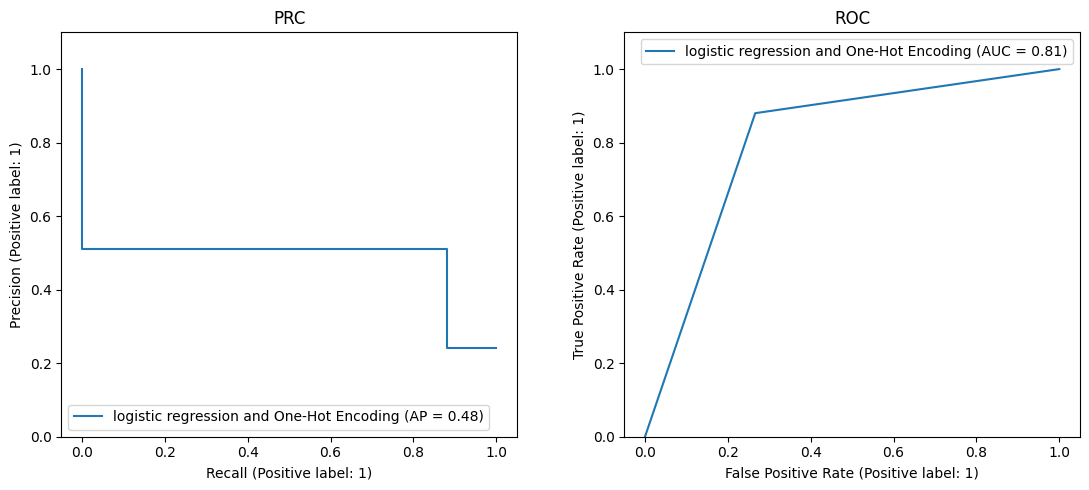

In [189]:
y_pred = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'logistic regression and One-Hot Encoding')

In [190]:
#your code here
ohe_and_scaling = model.named_steps['ohe_and_scaling']

feature_res_0 = ohe_and_scaling.transformers_[0][1].get_feature_names_out()
feature_res_1 = ohe_and_scaling.transformers_[1][1].get_feature_names_out()

combined_feature_names = np.append(feature_res_0, feature_res_1.reshape(-1, 1))
feature_names = combined_feature_names
coefficients = np.abs(model.named_steps['logistic_regression'].coef_[0])

In [191]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('feature-selection', selector),
    ('logistic_regression', LogisticRegression(class_weight='balanced', random_state=777))

])
start = time.time()
model = pipeline.fit(X_train, y_train)
end = time.time()

ttime = end - start
print(f'time: {ttime}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


time: 0.7079288959503174


logistic regression and One-Hot Encoding metrics
AUC-PR: 0.69902
AUC-ROC: 0.79512


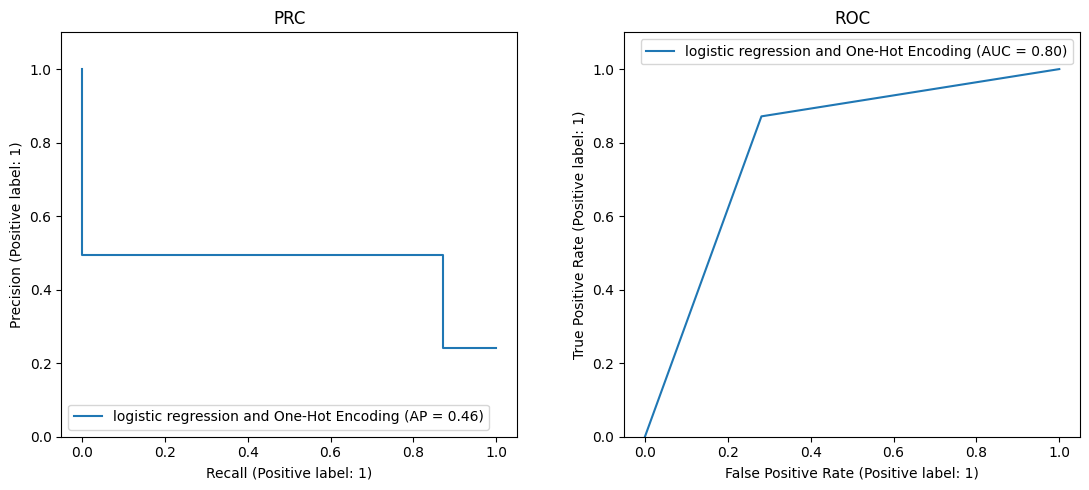

In [192]:
y_pred = model.predict(X_test)
depict_pr_roc(y_test, y_pred, 'logistic regression and One-Hot Encoding')

Похоже, что я запутался и сделал что-то не то...

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [ ]:
#your code here

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
#your code here

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [ ]:
#your code here

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [ ]:
df.head()

In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
# your code here

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [ ]:
# your code here

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
# your code here

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
#your code here

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [ ]:
#your code here

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
#your code here

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
#your code here

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




In [ ]:
#your code here

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ #your answer here

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
#your code here

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [ ]:
#your code here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ #your answer here

Йогурт с черникой, 2 таблетки и запил ТераФлю